In [2]:
class ConvertToRGB():
  def __call__(self, img):
    if img.mode != 'RGB':
      img.convert('RGB')
    return img

In [3]:
from torchvision import transforms
transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [4]:
from torchvision import datasets
data_dir = r"C:\Users\hp\Documents\Datasets\images\Brain_Cancer_MRI"
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 6056
    Root location: C:\Users\hp\Documents\Datasets\images\Brain_Cancer_MRI
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [5]:
print(len(dataset.classes))
dataset.classes

3


['brain_glioma', 'brain_menin', 'brain_tumor']

In [6]:
from torch.utils.data import DataLoader
batch_size = 32
dloader = DataLoader(dataset, batch_size=batch_size)

In [7]:
def mean_std(loader, max_batches=30):
    sum_, sum_sq, count = 0, 0, 0

    for i, (data, _) in enumerate(loader):
        if i == max_batches:
            break
        batch_size, channels, height, width = data.shape
        data = data.view(batch_size, channels, -1)
        sum_ += data.sum(dim=[0, 2])
        sum_sq += (data ** 2).sum(dim=[0, 2])
        count += batch_size * height * width

    mean = sum_ / count
    std = (sum_sq / count - mean ** 2).sqrt()
    return mean, std

mean, std = mean_std(dloader)

In [80]:
transform_norm = transforms.Compose([
    ConvertToRGB(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [81]:
dataset_norm = datasets.ImageFolder(data_dir, transform=transform_norm)

In [82]:
print(dataset.class_to_idx)

{'brain_glioma': 0, 'brain_menin': 1, 'brain_tumor': 2}


In [83]:
import torch
from torch.utils.data import random_split
g = torch.Generator().manual_seed(26)

train, val = random_split(dataset_norm, [.75, .25], generator = g)

In [84]:
from collections import Counter
import pandas as pd
from tqdm.notebook import tqdm
def class_counter(dataset):
    counter = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: counter[idx] for cat, idx in class_to_index.items()})

  0%|          | 0/4542 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Distribution of Classes in Training Dataset')

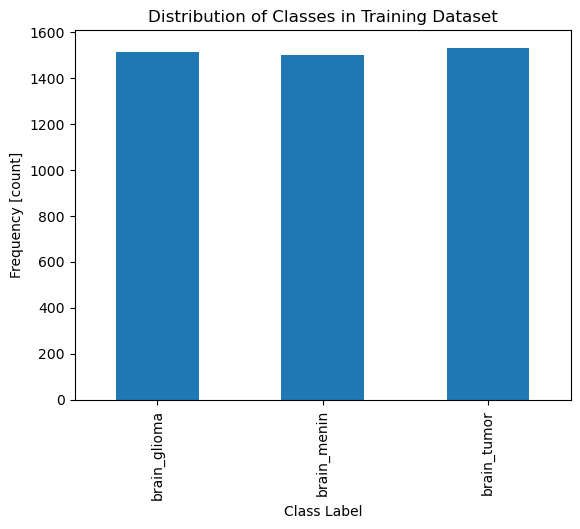

In [85]:
import matplotlib.pyplot as plt
train_dist = class_counter(train)
train_dist.plot(kind='bar')
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Training Dataset")

  0%|          | 0/1514 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Distribution of Classes in Validation Dataset')

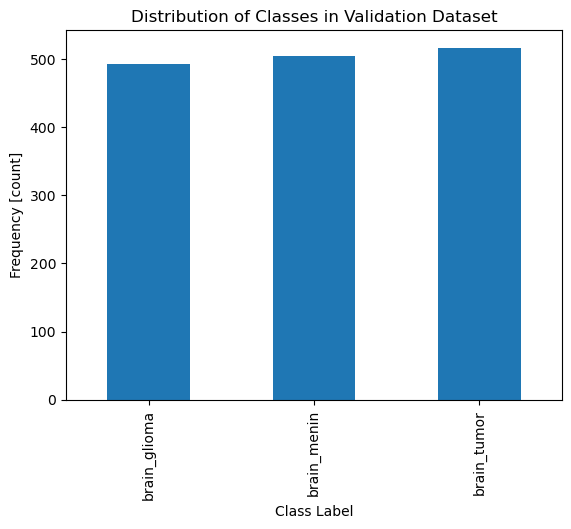

In [86]:
val_dist=class_counter(val)
val_dist.plot(kind='bar')
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Validation Dataset")

In [87]:
train_loader = DataLoader(train, batch_size, generator=g, shuffle=True)
val_loader = DataLoader(val, batch_size, generator=g)

In [129]:
import torch.nn as nn
model = nn.Sequential(

    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),

    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),

    nn.Flatten(),
    nn.Linear(in_features=50176, out_features=1024),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(in_features=256, out_features=3)
)

In [130]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=5e-4, lr=1e-5)

In [131]:
from torchinfo import summary
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 3]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─BatchNorm2d: 1-2                       [32, 16, 224, 224]        32
├─ReLU: 1-3                              [32, 16, 224, 224]        --
├─Dropout: 1-4                           [32, 16, 224, 224]        --
├─MaxPool2d: 1-5                         [32, 16, 112, 112]        --
├─Conv2d: 1-6                            [32, 32, 112, 112]        4,640
├─BatchNorm2d: 1-7                       [32, 32, 112, 112]        64
├─ReLU: 1-8                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-9                         [32, 32, 56, 56]          --
├─Conv2d: 1-10                           [32, 64, 56, 56]          18,496
├─BatchNorm2d: 1-11                      [32, 64, 56, 56]          128
├─ReLU: 1-12                             [32, 64, 56, 56]          --
├─MaxP

In [132]:
def train_epoch(model, optimizer, loss_fn, data_loader, device):
    training_loss = 0.0
    correct = 0
    total = 0
    model.train()

    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)
        loss = loss_fn(output, targets)

        loss.backward()
        optimizer.step()

        training_loss += loss.item() * inputs.size(0)

        preds = torch.argmax(output, dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    avg_loss = training_loss / len(data_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy

In [133]:
def score(model, data_loader, loss_fn, device):
    total_loss = 0
    total_correct = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    n_observations = data_loader.batch_size * len(data_loader)
    average_loss = total_loss / n_observations
    accuracy = total_correct / n_observations
    return average_loss, accuracy

In [134]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, )

In [135]:
def early_stopping(validation_loss, best_val_loss, counter):

    stop = False

    if validation_loss < best_val_loss:
        counter = 0
    else:
        counter += 1

    # Check if counter is >= patience (5 epochs in our case)
    # Set stop variable accordingly
    if counter >= 3:
        stop = True

    return counter, stop

In [136]:
def checkpointing(validation_loss, best_val_loss, model, optimizer, save_path):

    if validation_loss < best_val_loss:
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_val_loss,
            },
            save_path,
        )
        print(f"Checkpoint saved with validation loss {validation_loss:.4f}")

In [137]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device=None, scheduler=None, checkpoint_path=None, early_stopping=None):

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []

    best_val_loss = float("inf")
    early_stopping_counter = 0

    train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

    for epoch in range(1, epochs + 1):
        print("\n")
        print(f"Starting epoch {epoch}/{epochs}")

        train_loss, train_accuracy = train_epoch(model, optimizer, loss_fn, train_loader, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy*100:.4f}%")
        print(f"Validation loss: {validation_loss:.4f}")
        print(f"Validation accuracy: {validation_accuracy*100:.4f}%")

        lr = optimizer.param_groups[0]["lr"]
        learning_rates.append(lr)
        if scheduler:
            scheduler.step(validation_loss)

        if checkpoint_path:
            checkpointing(
                validation_loss, best_val_loss, model, optimizer, checkpoint_path
            )

        if early_stopping:
            early_stopping_counter, stop = early_stopping(
                validation_loss, best_val_loss, early_stopping_counter
            )
            if stop:
                print(f"Early stopping triggered after {epoch} epochs")
                break

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss

    return (
        learning_rates,
        train_losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        epoch,
    )

In [138]:
train_results = train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=10,
    device='cpu',
    scheduler=scheduler,
    checkpoint_path=r"C:\Users\hp\models\cnn_checkpoint.pth",
    early_stopping=early_stopping,
)

(
learning_rates,
    train_losses,
    valid_losses,
    train_accuracies,
    valid_accuracies,
    epochs,
) = train_results

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]



Starting epoch 1/10


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 1
Training loss: 0.9403
Training accuracy: 53.9410%
Validation loss: 0.8457
Validation accuracy: 62.9557%
Checkpoint saved with validation loss 0.8457


Starting epoch 2/10


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 2
Training loss: 0.8244
Training accuracy: 62.2413%
Validation loss: 0.8215
Validation accuracy: 63.8021%
Checkpoint saved with validation loss 0.8215


Starting epoch 3/10


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 3
Training loss: 0.7810
Training accuracy: 65.4998%
Validation loss: 0.8250
Validation accuracy: 61.0026%


Starting epoch 4/10


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 4
Training loss: 0.7432
Training accuracy: 67.2611%
Validation loss: 0.8592
Validation accuracy: 57.4219%


Starting epoch 5/10


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 5
Training loss: 0.7361
Training accuracy: 67.7015%
Validation loss: 0.8818
Validation accuracy: 53.4505%
Early stopping triggered after 5 epochs
